In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import pycountry

# Loading the data

In [2]:
#adapt folder path
data_folder = './Data/'
path_ba = data_folder + 'BeerAdvocate/'
#corresponds to a smaller version of reviews.txt
path_ba_reviews = data_folder + "reviews_small.txt"

In [3]:
#get csvs
ba_beers = pd.read_csv(path_ba + "beers.csv")
ba_users = pd.read_csv(path_ba + "users.csv")
ba_brew = pd.read_csv(path_ba + "breweries.csv")
ba_brew.set_index(ba_brew['id'], inplace = True)
ba_brew.pop('id')
ba_brew.sort_index(inplace=True)

In [4]:
reviews = pd.read_pickle(data_folder + "/matched_beer_data/ratings_with_text_ba")

# Data filtering and preparation

In [5]:
ba_users["nbr_reviews"].sum()

2589586

In [6]:
ba_beers

,beer_id,beer_name,brewery_id,brewery_name,style,nbr_ratings,nbr_reviews,avg,ba_score,bros_score,abv,avg_computed,zscore,nbr_matched_valid_ratings,avg_matched_valid_ratings
0,166064,Nashe Moskovskoe,39912,Abdysh-Ata (Абдыш Ата),Euro Pale Lager,0,0,NaN,NaN,NaN,4.7,NaN,NaN,0,NaN
1,166065,Nashe Pivovskoe,39912,Abdysh-Ata (Абдыш Ата),Euro Pale Lager,0,0,NaN,NaN,NaN,3.8,NaN,NaN,0,NaN
2,166066,Nashe Shakhterskoe,39912,Abdysh-Ata (Абдыш Ата),Euro Pale Lager,0,0,NaN,NaN,NaN,4.8,NaN,NaN,0,NaN
3,166067,Nashe Zhigulevskoe,39912,Abdysh-Ata (Абдыш Ата),Euro Pale Lager,0,0,NaN,NaN,NaN,4.0,NaN,NaN,0,NaN
4,166063,Zhivoe,39912,Abdysh-Ata (Абдыш Ата),Euro Pale Lager,0,0,NaN,NaN,NaN,4.5,NaN,NaN,0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
280818,19139,Kölsch Ale,885,Summit Station Restaurant & Brewery,Kölsch,3,3,2.71,NaN,NaN,5.0,2.713333,NaN,0,NaN
280819,19140,Nut Brown Ale,885,Summit Station Restaurant & Brewery,English Brown Ale,2,1,3.10,NaN,NaN,5.3,3.250000,NaN,0,NaN
280820,19146,Octoberfest,885,Summit Station Restaurant & Brewery,Märzen / Oktoberfest,0,0,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN
280821,2805,Scotch Ale,885,Summit Station Restaurant & Brewery,Scotch Ale / Wee Heavy,0,0,NaN,NaN,NaN,7.0,NaN,NaN,0,NaN


## brewerie list

In [7]:
#removing html tags
ba_brew['location'] = ba_brew['location'].apply(lambda x : x.split('<', 1)[0])
#separating country from states (for USA)
ba_brew['country'] = ba_brew['location'].apply(lambda x : x.split(',', 1)[0])

In [8]:
#find matching country iso codes
def find_iso(x):
    try:
        country = pycountry.countries.search_fuzzy(x)
        return country[0].alpha_3
    except:
        return None
country_list = ba_brew['country'].unique()
country_iso = {x: find_iso(x) for x in country_list} #look up table
ba_brew['country_code'] = ba_brew['country'].apply(lambda x: country_iso[x])

In [9]:
#special detailed dataframe for usa
brew_usa = ba_brew[ba_brew['country'] == 'United States']
states = brew_usa['location'].apply(lambda x : str(x.split(',', 1)[1])[1:] if ',' in x else None)
brew_usa = brew_usa.assign(states = states)

In [10]:
#beer count per country
beer_country = ba_brew.groupby(ba_brew["country_code"]).sum().sort_values(by = 'nbr_beers', ascending = False)
beer_states = brew_usa.groupby(brew_usa["states"]).sum().sort_values(by = 'nbr_beers', ascending = False)

# Data Visualisation

## stats about beers

### alcohol content (abv)

In [11]:
print(f"number of Nan in abv: {ba_beers['abv'].isna().sum()}")
print(f"number of beers on site: {len(ba_beers)}")

number of Nan in abv: 36024
number of beers on site: 280823


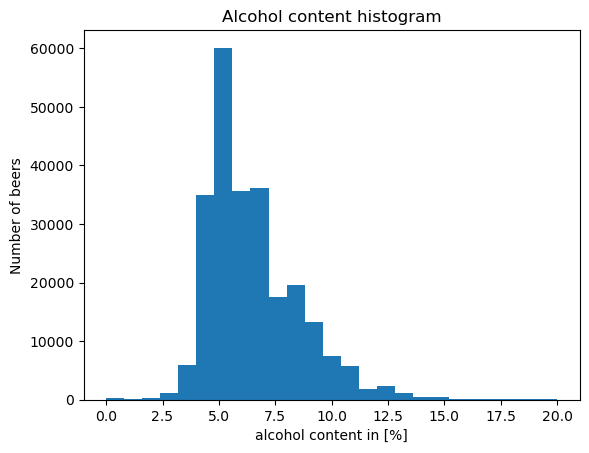

In [12]:
plt.hist(ba_beers['abv'].dropna(), bins=25, range=(0, 20))
plt.xlabel('alcohol content in [%]')
plt.ylabel('Number of beers')
plt.title('Alcohol content histogram');

### beer types

In [13]:
#number of types of beer
style_counts = ba_beers["style"].value_counts()
print(len(style_counts))

104


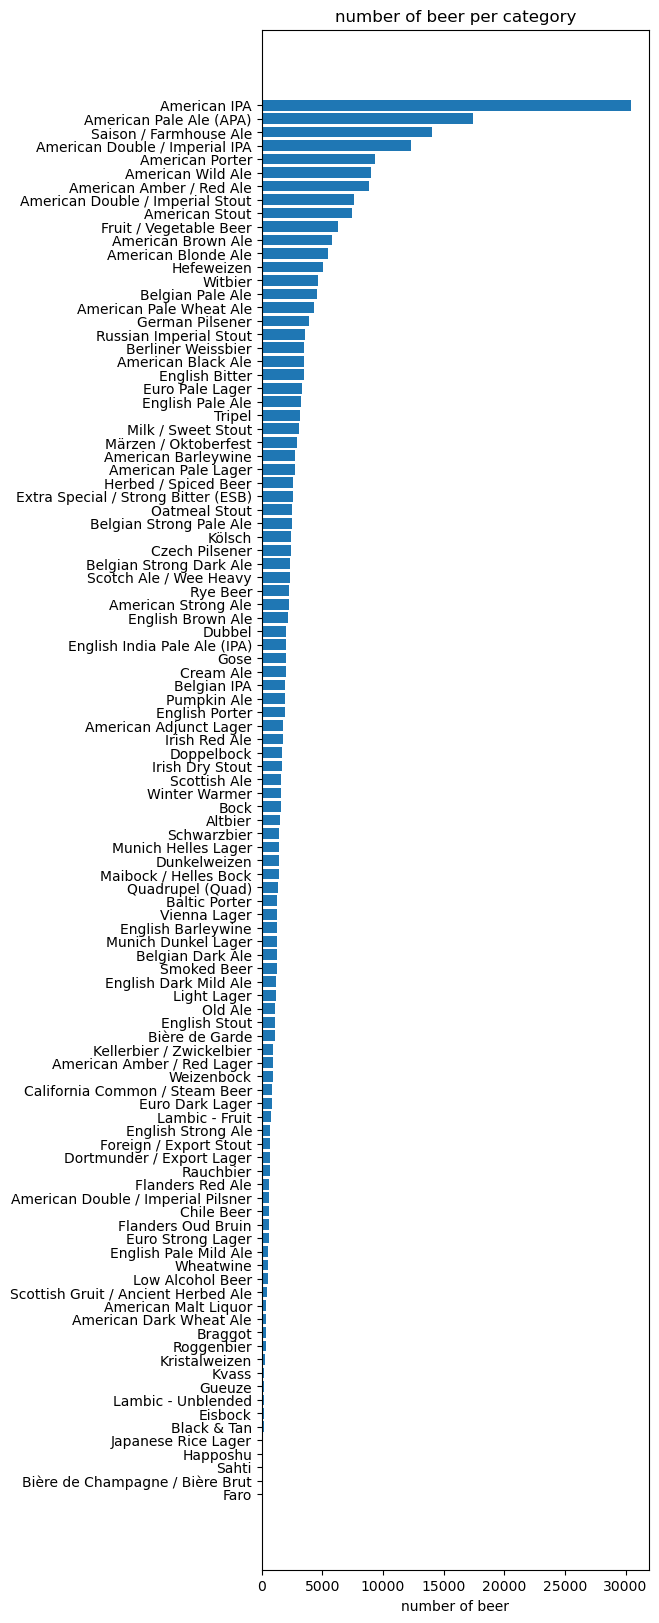

In [14]:
fig, ax = plt.subplots(figsize = (5, 20))
ax.barh(style_counts.index, style_counts, align='center')
#ax.set_yticks(style_counts.index(), labels=people)
ax.invert_yaxis()  # labels read top-to-bottom
ax.set_xlabel('number of beer')
ax.set_title('number of beer per category')
plt.show()

In [15]:
american_style = [x for x in style_counts.index if "American" in x]
german_style = [x for x in style_counts.index if ("German" in x or "Munich" in x)]

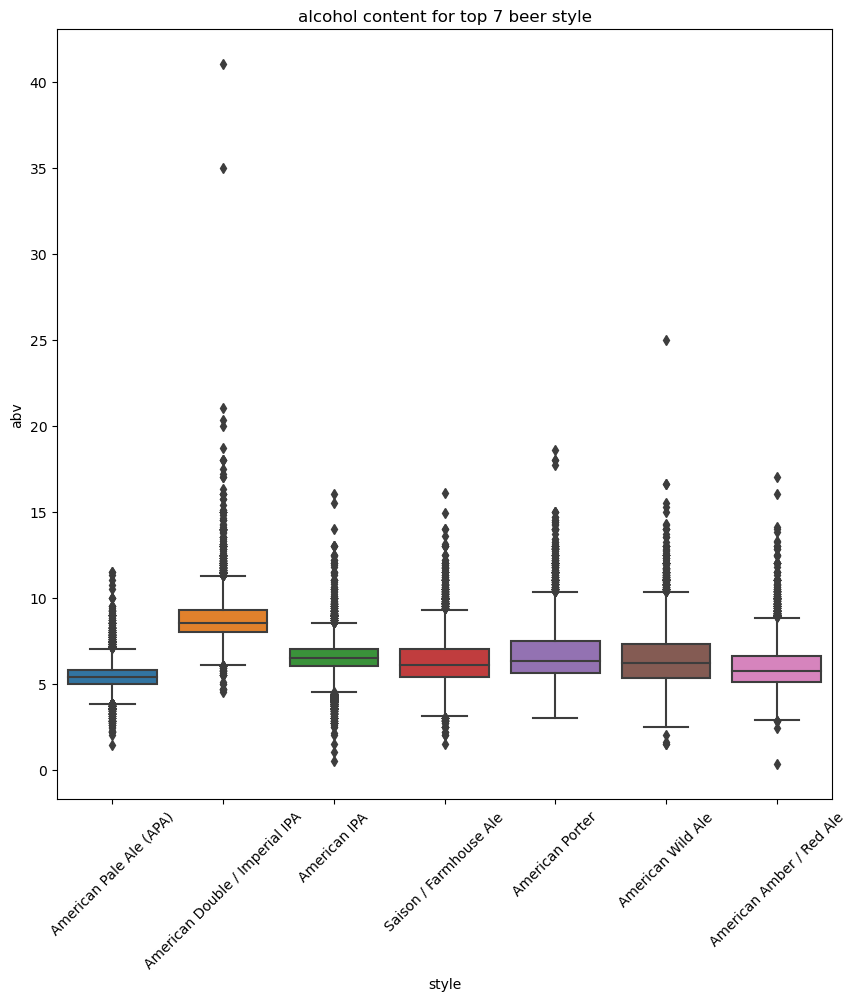

In [16]:
#alcohol content amongst top 10 most popular style
result = ba_beers.groupby(ba_beers["style"]).filter(lambda x: len(x) > 8000)
fig, ax = plt.subplots(figsize=(10,10))
sns.boxplot(x='style', y='abv', data=result, ax=ax)
plt.xticks(rotation = 45) # Rotates X-Axis Ticks by 45-degrees
plt.title("alcohol content for top 7 beer style")
plt.show()

## Reviews as a time serie

<AxesSubplot:xlabel='date'>

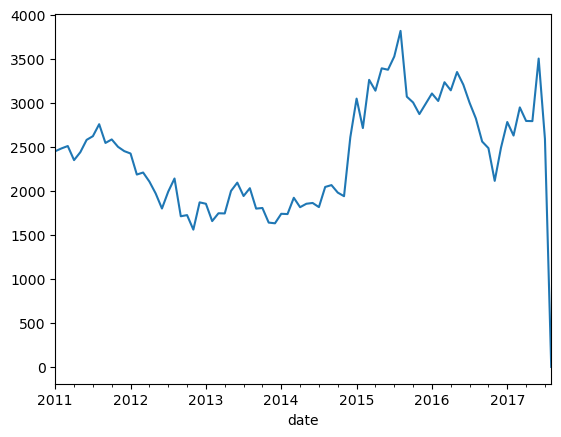

In [17]:
rev_month = reviews.groupby(reviews.index.to_period('M')).size()
rev_month.loc[rev_month.index.year > 2010].plot()

# Analysis of review

## user base

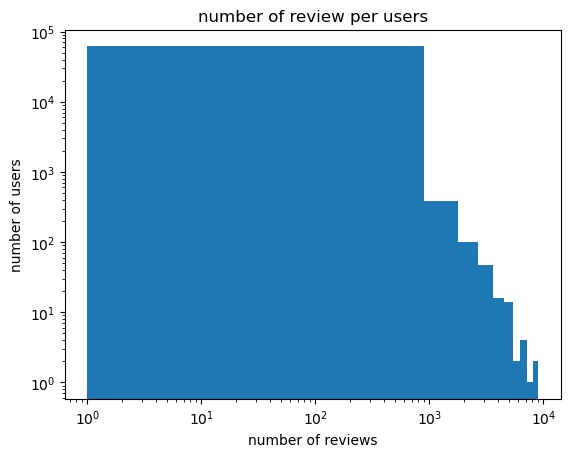

In [18]:
#number of review per users
#WRONG USE LOG BINS PLS
ba_users.loc[ba_users['nbr_reviews'] >= 1]['nbr_reviews'].plot(kind='hist', logx=True, logy=True)
plt.xlabel("number of reviews")
plt.ylabel("number of users")
plt.title("number of review per users")
plt.show()

## Beer ranking

In [19]:
#ranking of beers
ba_beers.loc[ba_beers['nbr_reviews'] > 100].sort_values(by = "avg", ascending = False)

,beer_id,beer_name,brewery_id,brewery_name,style,nbr_ratings,nbr_reviews,avg,ba_score,bros_score,abv,avg_computed,zscore,nbr_matched_valid_ratings,avg_matched_valid_ratings
182335,78820,Kentucky Brunch Brand Stout,23222,Toppling Goliath Brewing Company,American Double / Imperial Stout,610,117,4.84,100.0,NaN,12.0,4.834836,NaN,0,NaN
114605,146770,Very Hazy,28743,Tree House Brewing Company,American Double / Imperial IPA,654,107,4.77,100.0,NaN,8.6,4.727156,NaN,0,NaN
114544,136936,Good Morning,28743,Tree House Brewing Company,American Double / Imperial Stout,1023,206,4.77,100.0,99.0,8.4,4.786970,NaN,0,NaN
114561,87846,King Julius,28743,Tree House Brewing Company,American Double / Imperial IPA,765,125,4.74,100.0,NaN,8.3,4.746837,NaN,0,NaN
212296,110635,Hunahpu's Imperial Stout - Double Barrel Aged,17981,Cigar City Brewing,American Double / Imperial Stout,1470,142,4.71,100.0,NaN,11.0,4.748163,NaN,0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
137003,3734,Michelob Ultra,29,Anheuser-Busch,Light Lager,2315,610,1.85,47.0,36.0,4.2,1.877218,NaN,0,NaN
137016,1524,Natural Light,29,Anheuser-Busch,Light Lager,2104,540,1.83,47.0,37.0,4.2,1.689358,NaN,0,NaN
136908,37424,Bud Light & Clamato Chelada,29,Anheuser-Busch,Fruit / Vegetable Beer,405,152,1.78,49.0,NaN,4.2,1.833827,NaN,0,NaN
136948,52480,Budweiser Select 55,29,Anheuser-Busch,Light Lager,575,144,1.74,47.0,NaN,2.4,1.597409,NaN,0,NaN


In [20]:
#most popular us beer
ba_beers.loc[ba_beers["beer_name"] == 'Bud Light']

,beer_id,beer_name,brewery_id,brewery_name,style,nbr_ratings,nbr_reviews,avg,ba_score,bros_score,abv,avg_computed,zscore,nbr_matched_valid_ratings,avg_matched_valid_ratings
136907,1320,Bud Light,29,Anheuser-Busch,Light Lager,5878,1443,1.93,48.0,43.0,4.2,1.859842,NaN,0,NaN


# Geographical representation

In [21]:
import geoplot as gplt
import geopandas as gpd
import geoplot.crs as gcrs
import imageio
import pandas as pd
import pathlib
import matplotlib.pyplot as plt
import mapclassify as mc
import numpy as np


In [22]:
world = gpd.read_file(data_folder + "maps/world-administrative-boundaries.shp", encoding = 'utf-8')
world = world.merge(beer_country, how = "left", left_on="iso3", right_index = True, )
world = world.sort_values(by = "nbr_beers", ascending = False)
world['log_beers'] = world['nbr_beers'].apply(lambda x: np.log10(x) if x >= 1 else 0)

In [23]:
beer_country

,nbr_beers
country_code,
USA,276565
CAN,16993
GBR,11453
DEU,6180
BEL,4485
...,...
TJK,1
CAF,1
SSD,1


c:\Users\matth\anaconda3\envs\ADA\lib\site-packages\geoplot\geoplot.py:982: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for subgeom in geom:


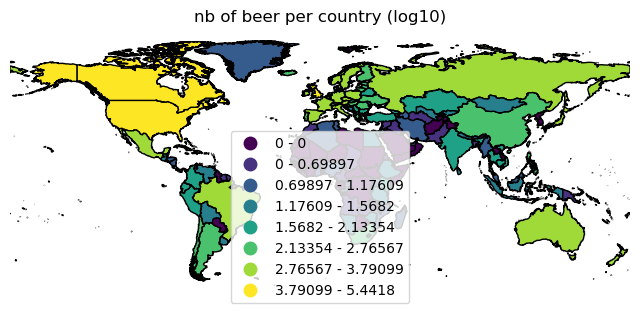

In [24]:
#number of beers per country (log)
scheme = mc.FisherJenks(world['log_beers'], k=8)
gplt.choropleth(world, hue="log_beers", legend=True, scheme=scheme)
plt.title("nb of beer per country (log10)")
plt.show()

In [25]:
beer_states.index.values

array(['California', 'Pennsylvania', 'Colorado', 'Illinois', 'New York',
       'Oregon', 'Florida', 'Washington', 'Massachusetts', 'Michigan',
       'North Carolina', 'Virginia', 'Ohio', 'Arizona', 'Indiana',
       'Minnesota', 'Wisconsin', 'Texas', 'Maryland', 'Missouri',
       'New Jersey', 'Connecticut', 'Delaware', 'Vermont', 'Iowa',
       'New Hampshire', 'Georgia', 'Maine', 'South Carolina', 'Tennessee',
       'New Mexico', 'Kentucky', 'Idaho', 'Kansas', 'Montana', 'Alaska',
       'Nebraska', 'Nevada', 'Utah', 'Louisiana', 'Alabama', 'Wyoming',
       'Rhode Island', 'Hawaii', 'South Dakota', 'Oklahoma', 'Arkansas',
       'West Virginia', 'North Dakota', 'Mississippi', 'United States'],
      dtype=object)

In [27]:
contiguous_usa

,state,adm1_code,population,geometry,nbr_beers,beer_per_capita
6,California,USA-3521,37253956,"POLYGON ((-114.35490 34.46467, -114.16597 34.2...",35587.0,0.000955
46,Pennsylvania,USA-3560,12702379,"POLYGON ((-74.89175 40.08179, -75.12882 39.949...",22710.0,0.001788
7,Colorado,USA-3522,5029196,"POLYGON ((-102.05017 40.00082, -102.04012 38.4...",18181.0,0.003615
32,Illinois,USA-3546,12830632,"POLYGON ((-90.64082 42.50536, -89.62005 42.505...",14993.0,0.001169
45,New York,USA-3559,19378102,"POLYGON ((-74.67903 41.35549, -74.84044 41.426...",13179.0,0.000680
10,Oregon,USA-3525,3831074,"POLYGON ((-117.02825 42.00002, -117.02825 41.9...",11973.0,0.003125
28,Florida,USA-3542,18801310,"POLYGON ((-80.05654 26.88000, -80.08801 26.205...",11415.0,0.000607
4,Washington,USA-3519,6724540,"POLYGON ((-116.99807 46.33017, -116.90653 46.1...",10786.0,0.001604
23,Massachusetts,USA-3513,6547629,"POLYGON ((-69.88480 41.92276, -69.96521 41.636...",10507.0,0.001605
48,Michigan,USA-3562,9883640,"POLYGON ((-90.39528 46.61168, -90.35559 46.673...",10169.0,0.001029


c:\Users\matth\anaconda3\envs\ADA\lib\site-packages\geoplot\geoplot.py:56: UserWarning: The data being passed to "hue" includes null values. You probably want to remove these before plotting this data with geoplot.
  warnings.warn(


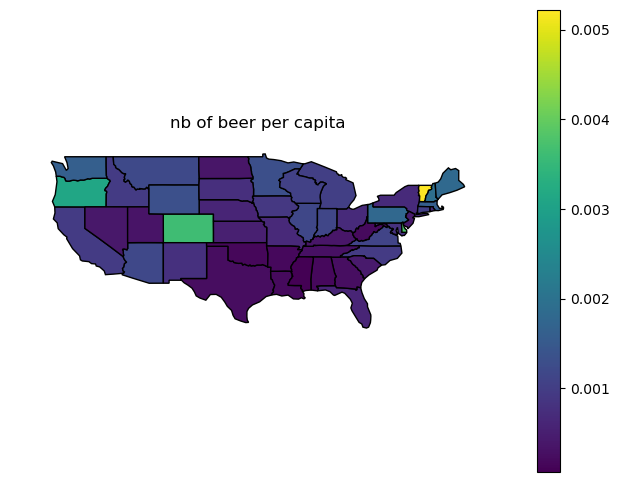

In [26]:
contiguous_usa = gpd.read_file(gplt.datasets.get_path("contiguous_usa"))
contiguous_usa = contiguous_usa.merge(beer_states, how = "left", left_on="state", right_index = True)
contiguous_usa = contiguous_usa.sort_values(by = "nbr_beers", ascending = False)
contiguous_usa["beer_per_capita"] = contiguous_usa.apply(lambda x: 0 if x["nbr_beers"] == np.nan else x["nbr_beers"]/x["population"], axis = 1)
gplt.choropleth(contiguous_usa, hue="nbr_beers", legend=True)
plt.title("nb of beer per state")
plt.show()